In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import pyreadr
import mercantile
from shapely.geometry import shape
import networkx as nx
import seaborn as sn
import pickle
import scipy.sparse as sp
from scipy.optimize import least_squares
import datetime
import lmfit
from sklearn import metrics
import math
from shapely.wkt import loads as load_wkt


## Importing Data

In [2]:
#################
# Load datasets #
#################

root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results'

root_base = root_results+'/Base Network'

# Load LSCC
root_lscc = root_base+'/base_network_lscc.npz'
with open(root_lscc, 'rb') as handle:
        lscc_dict = pickle.load(handle)
        
##############################
# Generate DiGraph from data #
##############################

lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)
lscc_nodes = list(lscc.nodes())
n_nodes = len(lscc_nodes)

# Store node numbers
node_numbers = {i : lscc_nodes[i] for i in range(n_nodes)}

# Load geom_dict
root_geom_dict = root_base+'/base_geom_dict.pickle'
with open(root_geom_dict, 'rb') as handle:
        geom_dict = pickle.load(handle)
# Gemo dict for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
A_LSCC_array = A_LSCC.toarray()
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)

# Subtract self-loops
B_LSCC_array = A_LSCC - np.diag(np.diag(A_LSCC.toarray()))
B_LSCC = sp.csr_matrix(B_LSCC_array)

# Import NUTS shape files
root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data/'
root_map = root_data+'/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

# Get NUTS2
gdf_NUTS2 = gdf_NUTS3.copy()
gdf_NUTS2['nuts'] = [gdf_NUTS2['nuts'][i][:4] for i in range(179)]
gdf_NUTS2 = gdf_NUTS2.dissolve(by='nuts')

# Get NUTS1
gdf_NUTS1 = gdf_NUTS3.copy()
gdf_NUTS1['nuts'] = [gdf_NUTS1['nuts'][i][:3] for i in range(179)]
gdf_NUTS1 = gdf_NUTS1.dissolve(by='nuts')

# Load NUTS3 data
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results/'
root_NUTS3_base = root_results+'/NUTS1_Base/'+'MOVEMENT_QUADKEY_NUTS3_GB.csv'
df_NUTS = pd.read_csv(root_NUTS3_base)
print('Shape of NUTS3 data:', df_NUTS.shape)

# Delete _ in front of quadkeys
quadkeys = [df_NUTS['quadkey'][i][1:] for i in range(df_NUTS.shape[0])]

# Get NUTS3 region names
NUTS3 = df_NUTS.columns.values.tolist()[1:]

# Get NUTS2 regions
to_NUTS2 = {NUTS3[i] : NUTS3[i][:4] for i in range(len(NUTS3))}
NUTS2_index = {list(to_NUTS2.values())[i] : i for i in range(len(to_NUTS2))}

# Get NUTS1 regions
to_NUTS1 = {NUTS3[i] : NUTS3[i][:3] for i in range(len(NUTS3))}
NUTS1_index = {list(to_NUTS1.values())[i] : i for i in range(len(to_NUTS1))}

# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)
print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_NUTS3 = {quadkeys[i] : max_rule[i] for i in range(df_NUTS.shape[0])}

# Generate NUTS3 Id's for LSCC nodes
NUTS3_id = np.asarray([quadkey_NUTS3[list(lscc.nodes())[i]] for i in range(n_nodes)])
print('NUTS3 communities in LSCC:', len(set(NUTS3_id)))

# Generate NUTS2 Id's
NUTS2_id = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS2 communities in LSCC:', len(set(NUTS2_id)))

# Generate NUTS1 Id's
NUTS1_id = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS1 communities in LSCC:', len(set(NUTS1_id)))

# create dictionary that goes from NUTS name to number
NUTS3_dict_no = { df_NUTS.columns[1:][i] : i for i in range(len(df_NUTS.columns[1:]))}

# save map gdf
map_gdf.to_file(root_results)

Shape of NUTS3 data: (5436, 180)
The max is obtained in average with: 0.93
NUTS3 communities in LSCC: 170
NUTS2 communities in LSCC: 42
NUTS1 communities in LSCC: 12


## Import data and preprocessing

In [3]:
###############
# Import data #
###############


# import base lscc's for each network
root_base = root_results+'/NUTS1_Base/'
with open(root_base+'/NUTS1_base_networks_lscc.npz', 'rb') as handle:
        NUTS1_networks_lscc = pickle.load(handle)


root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results'

df = pd.read_csv(root_results+'/Timeseries/FilteredDataFrame')
# Converting the quadkeys to strings
df['start_quadkey'] = df['start_quadkey'].astype(str)
df['end_quadkey'] = df['end_quadkey'].astype(str)
# adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

# Replace nan by 0
df = df.fillna(0)

###########################
# Get dates of timeseries #
###########################

# Get start and end dates
start_date = df.columns.values[2][:10]
end_date = df.columns.values[-1][:10]

# Generate DatetimeIndex
days = pd.date_range(start=start_date, end=end_date).date
n_days = len(days)
days_dm = np.asarray([str(days[i])[5:] for i in range(n_days)])
days_week = np.asarray(pd.date_range(start=start_date, end=end_date).weekofyear, dtype='int')
weeks = np.arange(days_week.min(),days_week.max())

# Store lockdown-date
lockdown_date = pd.to_datetime('20200324', format='%Y%m%d', errors='ignore')
lockdown_date_number = np.argwhere(days == lockdown_date).flatten()[0]

# Store second lockdown-date
second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(days == second_lockdown_date).flatten()[0]

df2 = df.copy() # make a copy of the dataframe

# get NUTS3, 2 and 1 ids for start and end quadkeys
NUTS3_id_start = np.asarray([quadkey_NUTS3[df2['start_quadkey'][i]] for i in range(df2.shape[0])])
NUTS2_id_start = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_start[i]]]] for i in range(df2.shape[0])])
NUTS1_id_start = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_start[i]]]] for i in range(df2.shape[0])])
NUTS3_id_end = np.asarray([quadkey_NUTS3[df2['end_quadkey'][i]] for i in range(df2.shape[0])])
NUTS2_id_end = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_end[i]]]] for i in range(df2.shape[0])])
NUTS1_id_end = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_end[i]]]] for i in range(df2.shape[0])])

#insert these id's as new columns
df2.insert(0,'start_NUTS1',NUTS1_id_start)
df2.insert(1,'end_NUTS1',NUTS1_id_end)

#function to get key of dictionary from its value
def getKeysByValues(dictOfElements, listOfValues):
    key_list = list(dictOfElements.keys())
    val_list = list(dictOfElements.values())
    listOfKeys = []
    for item  in listOfValues:
        position = val_list.index(item)
        listOfKeys.append(key_list[position])
    return  listOfKeys 

# get NUTS1 numbers and create dictionary
NUTS1_no = df2.start_NUTS1.unique()
NUTS1_no_dict = dict(zip(NUTS1_no, range(len(NUTS1_no))))

############## Create dataframes for each NUTS1 region ################

start_NUTS1_abbr = getKeysByValues(NUTS1_index,df2['start_NUTS1'])
end_NUTS1_abbr = getKeysByValues(NUTS1_index,df2['end_NUTS1'])

df2['start_NUTS1'] = np.asarray([ NUTS1_no_dict[df2['start_NUTS1'][i]] for i in range(df2.shape[0])])
df2['end_NUTS1'] = np.asarray([ NUTS1_no_dict[df2['end_NUTS1'][i]] for i in range(df2.shape[0])])

NUTS1_abbr_to_name_dict = {
    "UKC": "North East",
    "UKD": "North West",
    "UKE": "Yorkshire",
    "UKF": "East Midlands",
    "UKG":"West Midlands",
    "UKH":"East of England",
    "UKI":"London",
    "UKJ":"South East",
    "UKK":"South West",
    "UKL":"Wales",
    "UKM":"Scotland",
    "UKN":"Northern Ireland",
}

start_NUTS1_name = [NUTS1_abbr_to_name_dict[start_NUTS1_abbr[i]] for i in range(len(start_NUTS1_abbr))]
end_NUTS1_name = [NUTS1_abbr_to_name_dict[end_NUTS1_abbr[i]] for i in range(len(end_NUTS1_abbr))]

# create different dataframes for each NUTS1
dfs_NUTS1 = []
NUTS1_regions_indices = []
for i in range(len(NUTS1_no_dict)):
    #both are start and end are inside that region
    df_tmp = df2.loc[(df2['start_NUTS1'] == i) & (df2['end_NUTS1'] == i)]
    dfs_NUTS1.append(df_tmp)
    NUTS1_regions_indices.append(df_tmp.index)

NUTS1_numbers = getKeysByValues(NUTS1_no_dict,list(NUTS1_no_dict.values()))
NUTS1_abbr = getKeysByValues(NUTS1_index,NUTS1_numbers)
NUTS1_names = [NUTS1_abbr_to_name_dict[NUTS1_abbr[i]] for i in range(len(NUTS1_abbr))]

## Generation of daily DiGraphs for each NUTS1 region


In [4]:
compute_daily_digraphs_again = False
if compute_daily_digraphs_again == True:
    
    networks_NUTS1 = []
    for i,dfr in enumerate(dfs_NUTS1):
        dfr = dfr.reset_index()
       
        # Get the quadkey columns
        df_key = dfr.iloc[:,3:5]

        M = dfr.shape[1]-3
        networks = []
        for i in range(3,M,3):

            ##################
            # Get daily data #
            ##################

            df_mov = dfr.iloc[:,i+1:i+4]
            df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
            df_sum = pd.concat([df_key,df_sum],axis=1)
            ####################
            # Generate DiGraph #
            ####################

            N = len(df_sum)
            G = nx.DiGraph()
            # for each row, add nodes and weighted edge
            for j in range(0,N):

                start = df_sum['start_quadkey'][j]
                end = df_sum['end_quadkey'][j]
                weight = df_sum['movement'][j]
                G.add_node(start)
                G.add_node(end)
                if weight > 0.0:
                    G.add_weighted_edges_from([(start, end, weight)] )

            # Append DiGraph to list of networks
            networks.append(G)
        networks_NUTS1.append(networks)
        
    root4 = root_results+'/NUTS1_Timeseries'+'/timeseries_daily_digraphs_NUTS1.pkl'
    with open(root4, 'wb') as handle:
        pickle.dump(networks_NUTS1, handle, protocol=pickle.HIGHEST_PROTOCOL)

        
else:
    root4 = root_results+'/NUTS1_Timeseries'+'/timeseries_daily_digraphs_NUTS1.pkl'
    with open(root4, 'rb') as handle:
        networks_NUTS1 = pickle.load(handle)

## Statistics of Timeseries for each NUTS1

In [5]:
root_figure = '/Users/ignaciosacristanbarba/Documents/M4R/Figures/'

### Number of Trips for each NUTS1 region

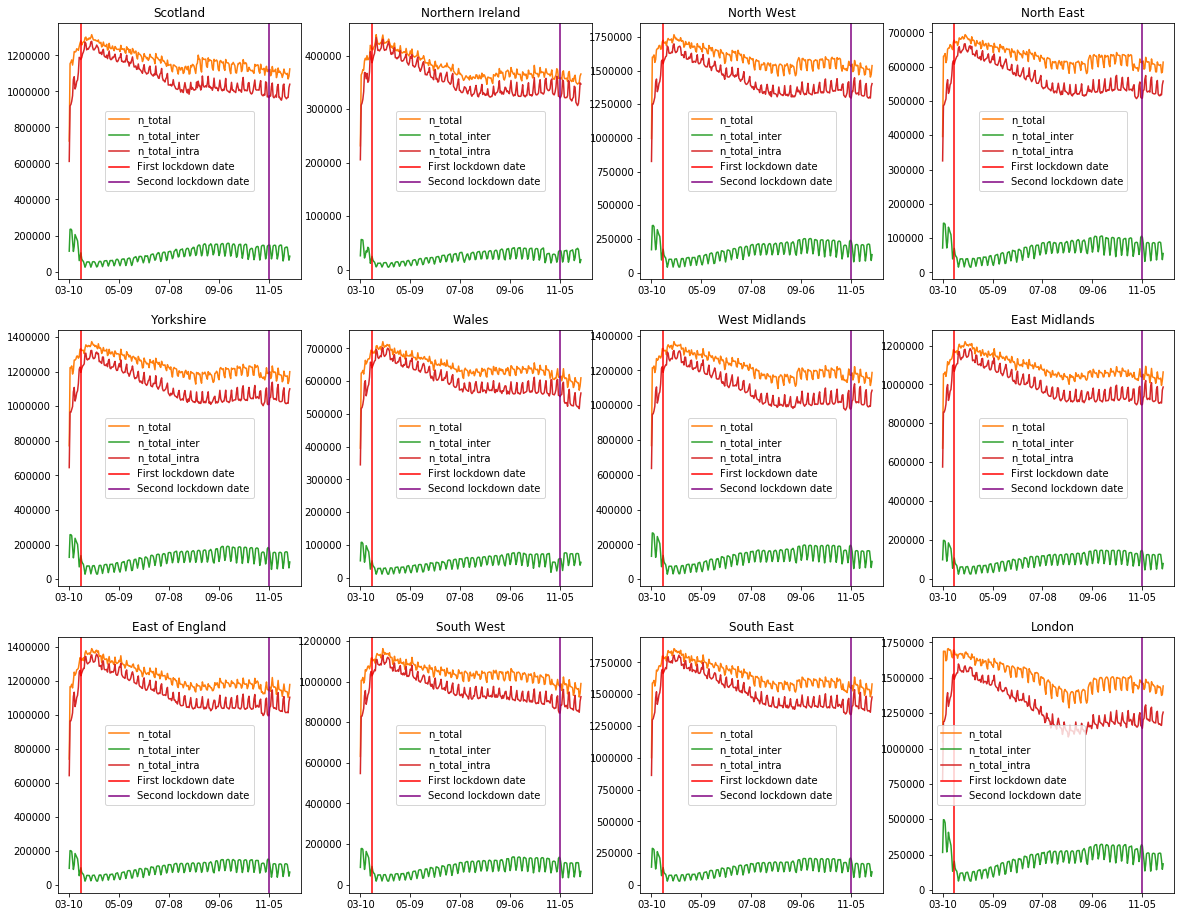

In [6]:
compute_trips_again = False
if compute_trips_again ==True:
    
    results_regions = []

    for j,networks_region in enumerate(networks_NUTS1):
        # add polygons as node attributes
        G = networks_region[0]
        quadkeys = list(G.nodes)
        n_nodes = len(quadkeys)
        polys = []
        #Iterates over the quadkeys to extract the tiles
        for quadkey in quadkeys:
            tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
            polys.append(tile.get('geometry'))
        geom = [shape(i) for i in polys]
        geom_dict = {quadkeys[i] : list(geom[i].centroid.bounds[:2]) for i in range(0,n_nodes)}
        n_networks = len(networks_region)
        for i in range(0,n_days):
            G = networks[i]
            nx.set_node_attributes(G,geom_dict,'geom')
        # Store node keys
        node_numbers = {i : list(networks_region[0].nodes())[i] for i in range(n_nodes)}
        # Gemo dicy for node keys
        geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}

        networks_adjacency = [nx.adjacency_matrix(networks_region[i]) for i in range(n_networks)]


        n_total = []
        n_total_inter = []
        n_total_intra = []
        for A in networks_adjacency:
            intra = np.diag(np.diag(A.toarray()))
            B = A - intra
            n_total.append(np.sum(A))
            n_total_inter.append(np.sum(B))
            n_total_intra.append(np.sum(intra))

        MA = 5
        
        results = pd.DataFrame({'day':days, 'n_total': n_total, 
                                'n_total_inter' : n_total_inter, 
                                'n_total_intra':n_total_intra
                               })
        results['MA_n_total'] = results['n_total'].rolling(window=MA).mean()
        results['MA_n_total_inter'] = results['n_total_inter'].rolling(window=MA).mean()   
        results['MA_n_total_intra'] = results['n_total_intra'].rolling(window=MA).mean()
        results_regions.append(results)
    
    root3 = root_results + '/NUTS1_Timeseries'+'/stats_daily_digraphs_NUTS1.pkl'
    with open(root3, 'wb') as handle:
        pickle.dump(results_regions, handle, protocol=pickle.HIGHEST_PROTOCOL)

        
else:
    root3 = root_results + '/NUTS1_Timeseries'+'/stats_daily_digraphs_NUTS1.pkl'
    with open(root3, 'rb') as handle:
        results_regions = pickle.load(handle)
    
    
fig, axes = plt.subplots(3, 4, figsize=(20,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)   
for i in range(3):
    for j in range(4):
        # Plot
        ax = axes[i, j]
        
        #ax.set_title('Region {}'.format(4*i+j))
        ax.set_title(NUTS1_names[4*i+j])        
        ax.plot(results_regions[4*i+j]['n_total'],label='n_total',color = 'C1')
        #ax.axhline(y = n_total_lscc, ls = '--', label = 'base',color='C1')
        ax.plot(results_regions[4*i+j]['n_total_inter'],label='n_total_inter',color='C2')
        #ax.axhline(y = n_total_inter_lscc, ls = '--', label = 'base inter',color='C2')
        ax.plot(results_regions[4*i+j]['n_total_intra'],label='n_total_intra',color='C3')
        #ax.axhline(y = n_total_intra_lscc, ls = '--', label = 'base intra',color='C3')
        ax.axvline(x = lockdown_date_number, label = 'First lockdown date', color = 'red')

        ax.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'purple')

        ticks = range(0,n_days,60)
        ax.set(xticks = ticks, xticklabels = days_dm[ticks])
        ax.legend()
        
plt.show()
fig.savefig(root_figure+'/NUTS1_Timeseries'+'/n_trips.png',dpi=fig.dpi,bbox_inches='tight')


### Size of LSCC and LWCC for each NUTS1 region

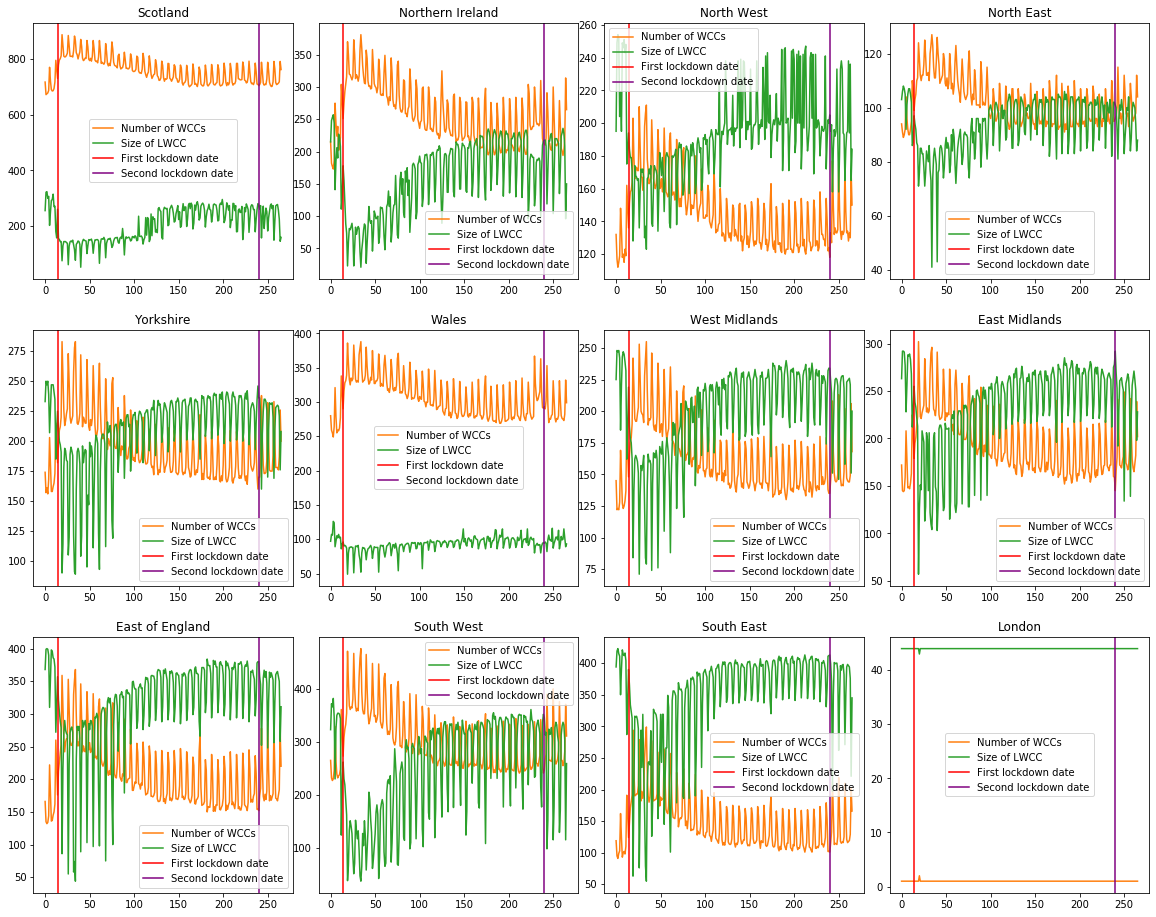

In [7]:
compute_n_components_again = False
if compute_n_components_again ==True:

    for j,networks_region in enumerate(networks_NUTS1):
        # add polygons as node attributes
        n_nodes = len(networks_region[0].nodes)

        # Compute number of WCCs and size of LWCC
        n_wcc = []
        s_lwcc = []

        for G in networks_region:
            n_wcc.append(nx.algorithms.components.number_weakly_connected_components(G))
            s_lwcc.append(len(max(nx.algorithms.components.weakly_connected_components(G), key=len)))


        # Store results in dataframe
        MA = 5
        results_regions[j]['n_wcc'] = n_wcc
        results_regions[j]['s_lwcc'] = s_lwcc
        results_regions[j]['MA_n_wcc'] = results_regions[j]['n_wcc'].rolling(window=MA).mean()
        results_regions[j]['MA_s_lwcc'] = results_regions[j]['s_lwcc'].rolling(window=MA).mean()

    root3 = root_results + '/NUTS1_Timeseries'+'/stats_daily_digraphs_NUTS1.pkl'
    with open(root3, 'wb') as handle:
        pickle.dump(results_regions, handle, protocol=pickle.HIGHEST_PROTOCOL)

        
else:
    root3 = root_results + '/NUTS1_Timeseries'+'/stats_daily_digraphs_NUTS1.pkl'
    with open(root3, 'rb') as handle:
        results_regions = pickle.load(handle)
    
    
fig, axes = plt.subplots(3, 4, figsize=(20,16))
fig.subplots_adjust(hspace=0.2, wspace=0.1)   
for i in range(3):
    for j in range(4):
        # Plot
        ax = axes[i, j]
        
        ax.set_title(NUTS1_names[4*i+j])   
       
        ax.plot(results_regions[4*i+j]['n_wcc'],label='Number of WCCs', color = 'C1')
        ax.plot(results_regions[4*i+j]['s_lwcc'],label='Size of LWCC', color = 'C2')
        ax.axvline(x = lockdown_date_number, color = 'red',label='First lockdown date')
        ax.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'purple')
        ticks = range(0,n_days,60)
        #ax.set_yscale('log')
        ax.legend()
plt.show()
fig.savefig(root_figure+'/NUTS1_Timeseries'+'/n_components.png',dpi=fig.dpi,bbox_inches='tight')


# Aggregate by Tier Restrictions

In [12]:
#################
# Load datasets #
#################

root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results'

root_base = root_results+'/Base Network'

# Load LSCC
root_lscc = root_base+'/base_network_lscc.npz'
with open(root_lscc, 'rb') as handle:
        lscc_dict = pickle.load(handle)
        
##############################
# Generate DiGraph from data #
##############################


# Import NUTS shape files
root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data/'
root_map = root_data+'/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'

map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

# Get NUTS2
gdf_NUTS2 = gdf_NUTS3.copy()
gdf_NUTS2['nuts'] = [gdf_NUTS2['nuts'][i][:4] for i in range(179)]
gdf_NUTS2 = gdf_NUTS2.dissolve(by='nuts')

# Get NUTS1
gdf_NUTS1 = gdf_NUTS3.copy()
gdf_NUTS1['nuts'] = [gdf_NUTS1['nuts'][i][:3] for i in range(179)]
gdf_NUTS1 = gdf_NUTS1.dissolve(by='nuts')

# Load NUTS3 data
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results/'
root_NUTS3_base = root_results+'/NUTS1_Base/'+'MOVEMENT_QUADKEY_NUTS3_GB.csv'
df_NUTS = pd.read_csv(root_NUTS3_base)
print('Shape of NUTS3 data:', df_NUTS.shape)

# Delete _ in front of quadkeys
quadkeys = [df_NUTS['quadkey'][i][1:] for i in range(df_NUTS.shape[0])]

# Get NUTS3 region names
NUTS3 = df_NUTS.columns.values.tolist()[1:]

# Get NUTS2 regions
to_NUTS2 = {NUTS3[i] : NUTS3[i][:4] for i in range(len(NUTS3))}
NUTS2_index = {list(to_NUTS2.values())[i] : i for i in range(len(to_NUTS2))}

# Get NUTS1 regions
to_NUTS1 = {NUTS3[i] : NUTS3[i][:3] for i in range(len(NUTS3))}
NUTS1_index = {list(to_NUTS1.values())[i] : i for i in range(len(to_NUTS1))}

# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)
print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_NUTS3 = {quadkeys[i] : max_rule[i] for i in range(df_NUTS.shape[0])}

# Generate NUTS3 Id's for LSCC nodes
NUTS3_id = np.asarray([quadkey_NUTS3[list(lscc.nodes())[i]] for i in range(n_nodes)])
print('NUTS3 communities in LSCC:', len(set(NUTS3_id)))

# Generate NUTS2 Id's
NUTS2_id = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS2 communities in LSCC:', len(set(NUTS2_id)))

# Generate NUTS1 Id's
NUTS1_id = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS1 communities in LSCC:', len(set(NUTS1_id)))

Shape of NUTS3 data: (5436, 180)
The max is obtained in average with: 0.93
NUTS3 communities in LSCC: 170
NUTS2 communities in LSCC: 42
NUTS1 communities in LSCC: 12


In [13]:
# save NUTS3 geodataframe 
gdf_NUTS3.to_file(root_results+'/NUTS3_graph'+'/gdf_NUTS3.shp')

### Getting names of Local Authotities (LADS) under tiers 2 & 3

In [14]:
# getting names of Local Authotities (LADS) under tier 3

# Get Local Authotities names under tier 3
root3 = root_data + 'Tier3.txt'
file = open(root3, 'r') 
tier3_LADS_names = []
element = ''
while 1: 
    # read by character 
    char = file.read(1)  
    element += char
    if char == ',':
        if element[0] == ' ':
            tier3_LADS_names.append(element[1:-1])
        else:
            tier3_LADS_names.append(element[:-1])
        element = ''
    if not char:  
        break       

# getting names of LADS under tier 2
root3 = root_data + 'Tier2.txt'
file = open(root3, 'r') 
tier2_LADS_names = []
element = ''
while 1: 
    # read by character 
    char = file.read(1)  
    
    element += char
    
    if char == ',':
        if element[0] == ' ':
            tier2_LADS_names.append(element[1:-1])
        else:
            tier2_LADS_names.append(element[:-1])
        element = ''
    
    if not char:  
        break 

##### Lookup matching local authority to NUTS3

In [15]:
# import NUTS lookup
root_lookup = root_data + '/NUTS_lookup.xlsx'
lookup_df = pd.read_excel(root_lookup)


# do list of tier 2 and 3 NUTS3

tier3_NUTS3 = []
for i in range(lookup_df.shape[0]):
    LAD = lookup_df.loc[i,'LAD18NM']
    if LAD in tier3_LADS_names:
        tier3_NUTS3.append(lookup_df.loc[i,'NUTS318CD'])
        
tier3_NUTS3 = set(tier3_NUTS3)
tier3_NUTS3 = list(tier3_NUTS3)

tier2_NUTS3 = []
for i in range(lookup_df.shape[0]):
    LAD = lookup_df.loc[i,'LAD18NM']
    if LAD in tier2_LADS_names:
        tier2_NUTS3.append(lookup_df.loc[i,'NUTS318CD'])
        
tier2_NUTS3 = set(tier2_NUTS3)
tier2_NUTS3 = list(tier2_NUTS3)

In [16]:
# remove from tier2 those that are in tier 3 at some point
temp = tier2_NUTS3.copy()
for i in range(len(temp)):
    if temp[i] in tier3_NUTS3:
        tier2_NUTS3.remove(temp[i])

In [17]:
print('NUTS3 regions under tier 2:',len(tier2_NUTS3))
print('NUTS3 regions under tier 3:',len(tier3_NUTS3))

NUTS3 regions under tier 2: 57
NUTS3 regions under tier 3: 21


In [18]:
# do a copy of dataframe 2
df3 = df2.copy()

#compute id's for start and end quadkeys
NUTS3_id_start = np.asarray([quadkey_NUTS3[df3['start_quadkey'][i]] for i in range(df3.shape[0])])
NUTS2_id_start = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_start[i]]]] for i in range(df3.shape[0])])
NUTS1_id_start = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_start[i]]]] for i in range(df3.shape[0])])

NUTS3_id_end = np.asarray([quadkey_NUTS3[df3['end_quadkey'][i]] for i in range(df3.shape[0])])
NUTS2_id_end = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_end[i]]]] for i in range(df3.shape[0])])
NUTS1_id_end = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_end[i]]]] for i in range(df3.shape[0])])

# insert them into the dataframe as new columns
df3.insert(0,'start_NUTS3',NUTS3_id_start)
df3.insert(1,'end_NUTS3',NUTS3_id_end)

# function to get key of dictionary by its value
def getKeysByValues(dictOfElements, listOfValues):
    key_list = list(dictOfElements.keys())
    val_list = list(dictOfElements.values())
    listOfKeys = []
    for item  in listOfValues:
        position = val_list.index(item)
        listOfKeys.append(key_list[position])
    return  listOfKeys 


In [19]:
# visualize London NUTS3 regions in the dataframe
df_london = df3.loc[(df3['start_NUTS1'] == 11)&(df3['end_NUTS1'] == 11)]
df_london

,start_NUTS3,end_NUTS3,start_NUTS1,end_NUTS1,start_quadkey,end_quadkey,2020-03-10_Tuesday_0000,2020-03-10_Tuesday_0800,2020-03-10_Tuesday_1600,2020-03-11_Wednesday_0000,...,2020-11-27_Friday_1600,2020-11-28_Saturday_0000,2020-11-28_Saturday_0800,2020-11-28_Saturday_1600,2020-11-29_Sunday_0000,2020-11-29_Sunday_0800,2020-11-29_Sunday_1600,2020-11-30_Monday_0000,2020-11-30_Monday_0800,2020-11-30_Monday_1600
28009,87,87,11,11,031313113323,031313113323,2842.0,1941.0,2374.0,2856.0,...,2817.0,2493.0,2322.0,3295.0,2516.0,2445.0,3517.0,2641.0,2134.0,2900.0
28012,87,72,11,11,031313113323,031313113332,66.0,101.0,178.0,53.0,...,121.0,33.0,41.0,64.0,27.0,41.0,43.0,45.0,74.0,126.0
28013,87,72,11,11,031313113323,031313113333,19.0,26.0,64.0,19.0,...,51.0,16.0,10.0,31.0,16.0,17.0,12.0,16.0,23.0,59.0
28014,87,105,11,11,031313113323,031313131011,0.0,0.0,23.0,0.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
28015,87,105,11,11,031313113323,031313131013,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39773,5,125,11,11,120202020202,031313131311,0.0,15.0,21.0,0.0,...,16.0,0.0,0.0,17.0,0.0,0.0,16.0,0.0,20.0,16.0
39775,5,5,11,11,120202020202,120202020022,0.0,18.0,18.0,0.0,...,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,12.0
39776,5,5,11,11,120202020202,120202020200,30.0,31.0,35.0,19.0,...,29.0,0.0,14.0,19.0,0.0,0.0,14.0,0.0,19.0,27.0
39777,5,5,11,11,120202020202,120202020201,0.0,25.0,17.0,0.0,...,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0


In [20]:
# compute numbers of the NUTS3 names
tier2_NUTS3_no = [NUTS3_dict_no[tier2_NUTS3[i]] for i in range(len(tier2_NUTS3))]
tier3_NUTS3_no = [NUTS3_dict_no[tier3_NUTS3[i]] for i in range(len(tier3_NUTS3))]

In [21]:
# create separate dataframes for NUTS3 under tier 2 and tier 3

df_tier2_NUTS3 = []
df_tier3_NUTS3 = []

count =0
for i in tier2_NUTS3_no:
    #both are start and end are inside that region
    df_tmp = df3.loc[(df3['start_NUTS3'] == i) & (df3['end_NUTS3'] == i)]
    df_tier2_NUTS3.append(df_tmp)
df_tier2_NUTS3 = pd.concat(df_tier2_NUTS3) 
    
for i in tier3_NUTS3_no:
    #both are start and end are inside that region
    df_tmp = df3.loc[(df3['start_NUTS3'] == i) & (df3['end_NUTS3'] == i)]
    df_tier3_NUTS3.append(df_tmp)
    
df_tier3_NUTS3 = pd.concat(df_tier3_NUTS3)

# Plot Tier restrictions

In [22]:
# Replace UKK24 with UKK21 and UKK25 with UKK21
NUTS3_replaced = []
for i in range(len(NUTS3)):
    code = NUTS3[i]
    if code == 'UKK24':
        NUTS3_replaced.append('UKK21')
    elif code == 'UKK25':
        NUTS3_replaced.append('UKK22')
    else:
        NUTS3_replaced.append(code)
        

In [23]:
#create df with restrictions by NUTS3
df_NUTS3_restrictions = pd.DataFrame(data = ['Tier1' for i in range(179)] , index = NUTS3_replaced,columns = ['Level'])
for i in range(df_NUTS3_restrictions.shape[0]):
    if df_NUTS3_restrictions.index[i] in tier2_NUTS3:
        df_NUTS3_restrictions.loc[df_NUTS3_restrictions.index[i],'Level'] = 'Tier2'
    if df_NUTS3_restrictions.index[i] in tier3_NUTS3:
        df_NUTS3_restrictions.loc[df_NUTS3_restrictions.index[i],'Level'] = 'Tier3'
  
df_NUTS3_restrictions = df_NUTS3_restrictions.reset_index()
df_NUTS3_restrictions = df_NUTS3_restrictions.rename(columns ={'index':'nuts'})


In [24]:
# Manchester and London coordinates to annotate
Manchester_coordinates = (-248491.003603233, 7032582.417602098)
Manchester_coordinates_text = (-458492.00361343, 7102582.417602098)

London_coordinates = (-16616.86726152207, 6684286.063548636)
London_coordinates_text = (-17616.86726152207, 6484286.063548636)

In [25]:
gdf_NUTS3.reset_index()

,index,nuts,geometry
0,0,UKC11,"MULTIPOLYGON (((-140100.796 7273967.189, -1393..."
1,1,UKC12,"MULTIPOLYGON (((-124544.003 7255295.758, -1207..."
2,2,UKC13,"POLYGON ((-160115.735 7248816.791, -159337.942..."
3,3,UKC14,"POLYGON ((-173591.479 7304026.243, -173858.506..."
4,4,UKC21,"MULTIPOLYGON (((-225447.036 7477581.936, -2259..."
...,...,...,...
174,174,UKN12,"MULTIPOLYGON (((-694461.511 7366675.248, -6942..."
175,175,UKN13,"POLYGON ((-653252.046 7266817.660, -656307.658..."
176,176,UKN14,"POLYGON ((-672986.711 7250889.888, -672310.451..."
177,177,UKN15,"POLYGON ((-653252.046 7266817.660, -654770.326..."


##### Remove Scotland Wales and NI

In [26]:
# do a copy of the NUTS geodataframe and remoce
gdf_NUTS3_c = gdf_NUTS3.copy().reset_index()
df_big = []
for i in range(gdf_NUTS3_c.shape[0]):
    if (gdf_NUTS3_c.loc[i,'nuts'][2] != 'M') and(gdf_NUTS3_c.loc[i,'nuts'][2] != 'L') and (gdf_NUTS3_c.loc[i,'nuts'][2] != 'N'):
        df_tmp = gdf_NUTS3_c.loc[(gdf_NUTS3_c['index'] ==i)]
        df_big.append(df_tmp)
gdf_NUTS3_c = pd.concat(df_big)



In [27]:
# merge the restrictions data frame with the geodataframe

gdf_NUTS3_results = pd.merge(gdf_NUTS3, df_NUTS3_restrictions, how="inner", on=["nuts"])


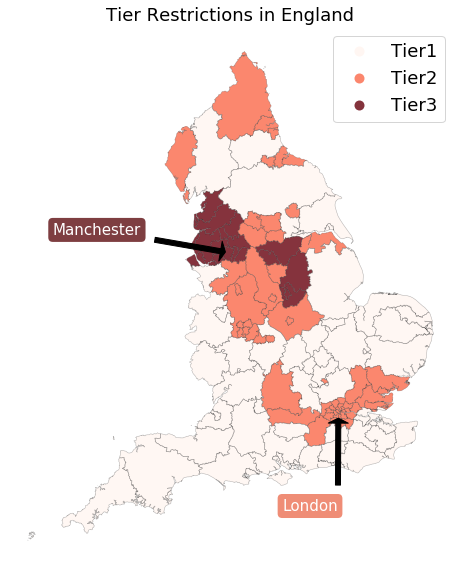

In [28]:
# plot 

gdf_NUTS3_results_c = pd.merge(gdf_NUTS3_c, df_NUTS3_restrictions, how="inner", on=["nuts"])

# Create subplots
fig, ax1 = plt.subplots(1)

# Adjust fig size and spaces between subplots
fig.subplots_adjust(hspace=0)
fig.set_size_inches(8,12)

gdf_NUTS3_c.boundary.plot(linewidth=0.5, ax=ax1, color = 'black',alpha = 0.3)
gdf_NUTS3_results_c.plot(linewidth=0.1, ax=ax1, column = 'Level', cmap='Reds',edgecolor='1',
                       legend = True,legend_kwds={'loc': 'best','fontsize':18},alpha = 0.8)

ax1.set_axis_off()

annotation3 = ax1.annotate('Manchester', xy=Manchester_coordinates,  xycoords='data',
            xytext=Manchester_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.10,width = 5,headwidth=20,headlength = 5,edgecolor='black'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': '#7E3E41', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation3.set_fontsize(15)
annotation3.set_color('white')

annotation4 = ax1.annotate('London', xy=London_coordinates,  xycoords='data',
            xytext=London_coordinates_text, textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.10,width = 5,headwidth=20,headlength = 5,edgecolor='black'),
            bbox={'boxstyle':"round,pad=0.3",'facecolor': '#EF8D76', 'pad': 2, 'edgecolor':'none'},
            
            horizontalalignment='right', verticalalignment='top',
            )
annotation4.set_fontsize(15)
annotation4.set_color('white')

ax1.set_title('Tier Restrictions in England',fontsize = 18)

fig.savefig(root_figure+'/Tiers'+'/NUTS3_tiers.pdf', dpi=fig.dpi,bbox_inches='tight')

# Generating Daily Digraphs for tiers 2 and 3

In [29]:
df_tier2_NUTS3 = df_tier2_NUTS3.reset_index(drop=True)     
# Get the quadkey columns
df_key = df_tier2_NUTS3.iloc[:,4:6]
M = df_tier2_NUTS3.shape[1]-3
tier2_NUTS3_networks = []
for i in range(5,M,3):

    ##################
    # Get daily data #
    ##################

    df_mov = df_tier2_NUTS3.iloc[:,i+1:i+4]
    df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
    df_sum = pd.concat([df_key,df_sum],axis=1)
    ####################
    # Generate DiGraph #
    ####################

    N = len(df_sum)
    G = nx.DiGraph()
    # for each row, add nodes and weighted edge
    for j in range(0,N):

        start = df_sum['start_quadkey'][j]
        end = df_sum['end_quadkey'][j]
        weight = df_sum['movement'][j]
        G.add_node(start)
        G.add_node(end)
        if weight > 0.0:
            G.add_weighted_edges_from([(start, end, weight)] )

    # Append DiGraph to list of networks
    tier2_NUTS3_networks.append(G)


In [30]:
df_tier3_NUTS3 = df_tier3_NUTS3.reset_index(drop=True)     
# Get the quadkey columns
df_key = df_tier3_NUTS3.iloc[:,4:6]
M = df_tier3_NUTS3.shape[1]-3
tier3_NUTS3_networks = []
for i in range(5,M,3):

    ##################
    # Get daily data #
    ##################

    df_mov = df_tier3_NUTS3.iloc[:,i+1:i+4]
    df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
    df_sum = pd.concat([df_key,df_sum],axis=1)
    ####################
    # Generate DiGraph #
    ####################

    N = len(df_sum)
    G = nx.DiGraph()
    # for each row, add nodes and weighted edge
    for j in range(0,N):

        start = df_sum['start_quadkey'][j]
        end = df_sum['end_quadkey'][j]
        weight = df_sum['movement'][j]
        G.add_node(start)
        G.add_node(end)
        if weight > 0.0:
            G.add_weighted_edges_from([(start, end, weight)] )

    # Append DiGraph to list of networks
    tier3_NUTS3_networks.append(G)


#### Plot number of trips of NUTS3 under the tier 2 and 3 restrictions

In [31]:
n_networks = len(tier2_NUTS3_networks)

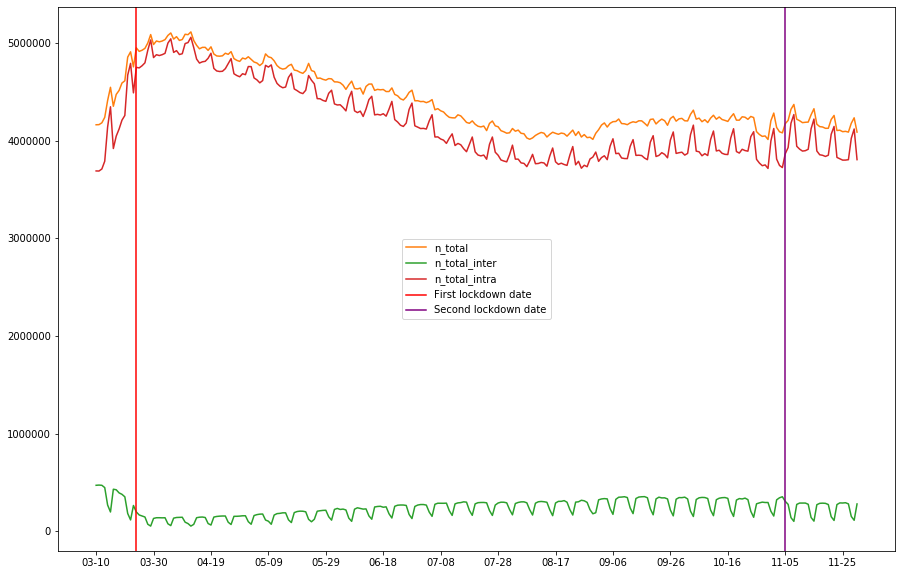

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [32]:
tier2_networks_adjacency = [nx.adjacency_matrix(tier2_NUTS3_networks[i]) for i in range(n_networks)]
compute_stats_again = True

if compute_stats_again == True:
    n_total = []
    n_total_inter = []
    n_total_intra = []
    for A in tier2_networks_adjacency:
        intra = np.diag(np.diag(A.toarray()))
        B = A - intra
        n_total.append(np.sum(A))
        n_total_inter.append(np.sum(B))
        n_total_intra.append(np.sum(intra))

    results = pd.DataFrame({'day':days, 'n_total': n_total, 
                            'n_total_inter' : n_total_inter, 
                            'n_total_intra':n_total_intra})
    
    root5 = root_results + '/Tiers'+'/tier2_stats_daily_digraphs.cvs'
    with open(root5, 'wb') as handle:
        results.to_csv(root5)
            
else:
    root5 = root_results + '/Tiers'+'/tier2_stats_daily_digraphs.cvs'
    with open(root5, 'rb') as handle:
        results = pd.read_csv(root5)


# Plot
fig, ax = plt.subplots(1,figsize =(15,10))
ax.plot(results['n_total'],label='n_total',color = 'C1')
ax.plot(results['n_total_inter'],label='n_total_inter',color='C2')
ax.plot(results['n_total_intra'],label='n_total_intra',color='C3')
ax.axvline(x = lockdown_date_number, label = 'First lockdown date', color = 'red')

ax.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'purple')

ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.legend()
plt.show()
fig.savefig(root_figure+'/Tiers'+'/tier2_ntrips.eps', dpi=fig.dpi,bbox_inches='tight')

In [33]:
n_networks = len(tier3_NUTS3_networks)

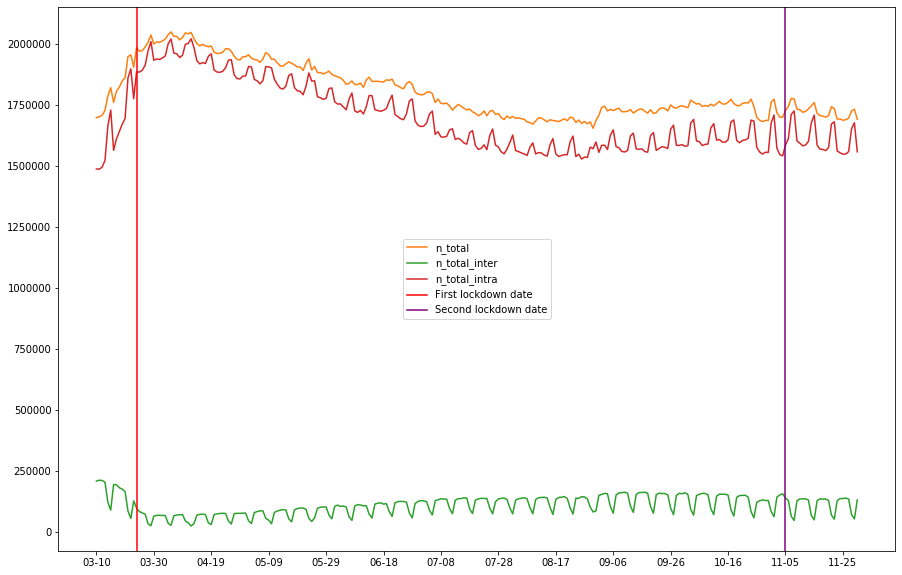

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [34]:
tier3_networks_adjacency = [nx.adjacency_matrix(tier3_NUTS3_networks[i]) for i in range(n_networks)]
compute_stats_again = True

if compute_stats_again == True:
    n_total = []
    n_total_inter = []
    n_total_intra = []
    for A in tier3_networks_adjacency:
        intra = np.diag(np.diag(A.toarray()))
        B = A - intra
        n_total.append(np.sum(A))
        n_total_inter.append(np.sum(B))
        n_total_intra.append(np.sum(intra))

    results = pd.DataFrame({'day':days, 'n_total': n_total, 
                            'n_total_inter' : n_total_inter, 
                            'n_total_intra':n_total_intra})
    
    root5 = root_results + '/Tiers'+'/tier3_stats_daily_digraphs.cvs'
    with open(root5, 'wb') as handle:
        results.to_csv(root5)
            
else:
    root5 = root_results + '/Tiers'+'/tier3_stats_daily_digraphs.cvs'
    with open(root5, 'rb') as handle:
        results = pd.read_csv(root5)


# Plot
fig, ax = plt.subplots(1,figsize =(15,10))
ax.plot(results['n_total'],label='n_total',color = 'C1')
ax.plot(results['n_total_inter'],label='n_total_inter',color='C2')
ax.plot(results['n_total_intra'],label='n_total_intra',color='C3')
ax.axvline(x = lockdown_date_number, label = 'First lockdown date', color = 'red')

ax.axvline(x = second_lockdown_date_number, label = 'Second lockdown date', color = 'purple')

ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.legend()
plt.show()
fig.savefig(root_figure+'/Tiers'+'/tier3_ntrips.eps', dpi=fig.dpi,bbox_inches='tight')

No visible differences between the tier 2 and 3 plots

# Creating graph of NUTS3 Regions


In [35]:
# pre-processing
df4 = df3.groupby(['start_NUTS3','end_NUTS3']).sum()
df4 = df4.drop(['start_NUTS1','end_NUTS1'],axis = 1)
df4 = df4.reset_index()

In [36]:

M = df4.shape[1]-1
networks = []
df_key = df4.iloc[:,0:2]
for i in range(1,M,3):

    ##################
    # Get daily data #
    ##################
    
    df_mov = df4.iloc[:,i+1:i+4]
    df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
    
    df_sum = pd.concat([df_key,df_sum],axis=1)
    
    ####################
    # Generate DiGraph #
    ####################

    N = len(df_sum)
    G = nx.DiGraph()
    # for each row, add nodes and weighted edge
    for j in range(0,N):

        start = df_sum['start_NUTS3'][j]
        
        end = df_sum['end_NUTS3'][j]
        weight = df_sum['movement'][j]
        G.add_node(start)
        G.add_node(end)
        if weight > 0.0:
            G.add_weighted_edges_from([(start, end, weight)] )

    # Append DiGraph to list of networks
    networks.append(G)

In [37]:
# PLOT MAP WITH NEW GRAPH
gdf_NUTS3_results['centroid_column'] = gdf_NUTS3_results.centroid

In [38]:
N = len(gdf_NUTS3_results.centroid)
locs = []
for i in range(N):
    pt = gdf_NUTS3_results['centroid_column'][i]
    #a = a.split(' ')
    a=[]
    a.append(float(pt.x))
    a.append(float(pt.y))
    locs.append(tuple(a))

In [39]:
NUTS3_locs_dict = {gdf_NUTS3_results['nuts'][i]: locs[i]  for i  in range(len(locs))}

#replace
NUTS3_dict_no['UKK21']= NUTS3_dict_no.pop('UKK24')
NUTS3_dict_no['UKK22']= NUTS3_dict_no.pop('UKK25')        

dict_keys_tmp = []
for i in range(len(NUTS3_locs_dict)):
    dict_keys_tmp.append(NUTS3_dict_no[list(NUTS3_locs_dict.keys())[i]])

NUTS3_no_loc_dict = {dict_keys_tmp[i]: list(NUTS3_locs_dict.values())[i] for i in range(len(NUTS3_locs_dict))}


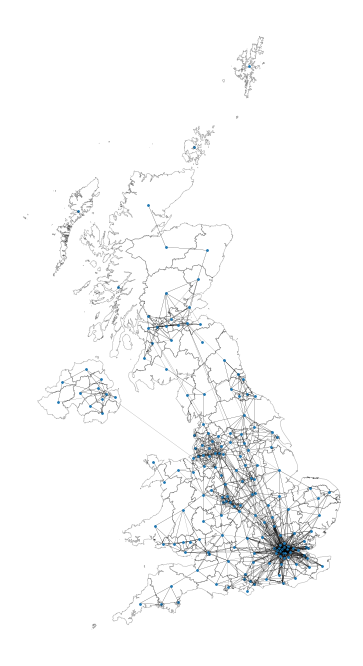

In [40]:
fig,ax =plt.subplots(1,figsize =(7,12))
nx.draw(networks[0],node_size = 3,width=0.1,ax = ax,pos = NUTS3_no_loc_dict,arrows = False)
gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax, color = 'black',alpha = 0.3)
fig.savefig(root_figure+'/NUTS3_graph'+'/netowork_visualization.svg', dpi=10,bbox_inches='tight')

# Base NUTS3 Network Visualization

In [41]:
# import the base network
df_base = pd.read_csv(root_results+'/Base Network'+'/BaseFilteredDataFrame.csv')

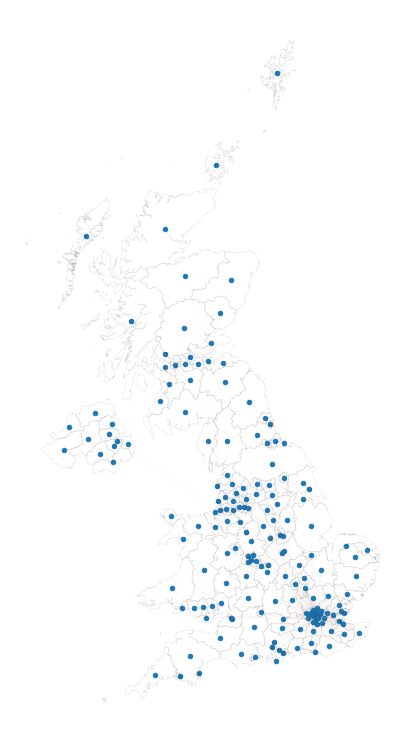

In [42]:
df_base = pd.read_csv(root_results+'/Base Network'+'/BaseFilteredDataFrame.csv')

# Converting the quadkeys to strings
df_base['start_quadkey'] = df_base['start_quadkey'].astype(str)
df_base['end_quadkey'] = df_base['end_quadkey'].astype(str)
# adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
df_base.loc[df_base['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df_base['start_quadkey']
df_base.loc[df_base['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df_base['end_quadkey']

# Replace nan by 0
df_base = df_base.fillna(0)

###########################
# Get dates of timeseries #
###########################

# Get start and end dates
start_date = df_base.columns.values[2][:10]
end_date = df_base.columns.values[-1][:10]

# do a copy of the base datafram
dfb = df_base.copy()

#compute the start and end id's of the nuts
NUTS3_id_start = np.asarray([quadkey_NUTS3[dfb['start_quadkey'][i]] for i in range(dfb.shape[0])])
NUTS2_id_start = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_start[i]]]] for i in range(dfb.shape[0])])
NUTS1_id_start = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_start[i]]]] for i in range(dfb.shape[0])])
NUTS3_id_end = np.asarray([quadkey_NUTS3[dfb['end_quadkey'][i]] for i in range(dfb.shape[0])])
NUTS2_id_end = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id_end[i]]]] for i in range(dfb.shape[0])])
NUTS1_id_end = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id_end[i]]]] for i in range(dfb.shape[0])])


# insert them as new columns
dfb.insert(0,'start_NUTS3',NUTS3_id_start)
dfb.insert(1,'end_NUTS3',NUTS3_id_end)

#group by NUTS3 & reset index
dfb = dfb.groupby(['start_NUTS3','end_NUTS3']).sum()
dfb = dfb.reset_index()

##### Daily aggregation and generation of graph #####

df_key = dfb.iloc[:,:2]
# Get daily movements by summation
M = dfb.shape[1]-1
days = []

for i in range(1,M,3):

    df_mov = dfb.iloc[:,i+1:i+4]
    df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
    days.append(df_sum)

# Compute weekly average
all_days = days[0]

for i in range(1,len(days)):
    all_days += days[i]
    
all_days = all_days/len(days)
df_mean = pd.concat([df_key,all_days],axis=1)

####################
# Generate DiGraph #
####################

N = len(df_mean)
G = nx.DiGraph()

# for each row, add nodes and weighted edge
for i in range(0,N):
    start = df_mean['start_NUTS3'][i]
    end = df_mean['end_NUTS3'][i]
    weight = df_mean['movement'][i]
    G.add_node(start)
    G.add_node(end)
    if weight > 0.0:
        G.add_weighted_edges_from([(start, end, weight)] )
        
# PLOT MAP WITH NEW GRAPH
gdf_NUTS3_results['centroid_column'] = gdf_NUTS3_results.centroid
gdf_NUTS3_results = gdf_NUTS3_results.set_geometry('centroid_column')
gdf_NUTS3_results

N = len(gdf_NUTS3_results.centroid)
locs = []
for i in range(N):
    pt = gdf_NUTS3_results['centroid_column'][i]
    #a = a.split(' ')
    a=[]
    a.append(float(pt.x))
    a.append(float(pt.y))
    locs.append(tuple(a))
    


# create dictionary for NUTS3 locs
NUTS3_locs_dict = {gdf_NUTS3_results['nuts'][i]: locs[i]  for i  in range(len(locs))}

# create same dictionary but with numbers
dict_keys_tmp = []
for i in range(len(NUTS3_locs_dict)):
    dict_keys_tmp.append(NUTS3_dict_no[list(NUTS3_locs_dict.keys())[i]])
NUTS3_no_loc_dict = {dict_keys_tmp[i]: list(NUTS3_locs_dict.values())[i] for i in range(len(NUTS3_locs_dict))}

# plot
fig,ax =plt.subplots(1,figsize =(7,14))
nx.draw(G,node_size = 20,width=0.01,ax = ax,pos = NUTS3_no_loc_dict,arrows = False,edge_color='#E9887B')
gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax, color = 'black',alpha = 0.1)
plt.show()
fig.savefig(root_figure+'/NUTS3_graph'+'/netowork_visualization.pdf', dpi=10,bbox_inches='tight')


### Base LWCC

In [43]:
lwcc_nodes = max(nx.weakly_connected_components(G), key=len)
lwcc = G.subgraph(lwcc_nodes)
lwcc_dict = nx.to_dict_of_dicts(lwcc)
A = nx.adjacency_matrix(lwcc)
lwcc_nodes_list = np.asarray(list(lwcc.nodes()))
s_lwcc = len(lwcc_nodes_list)
print('Number of nodes of LWCC:', s_lwcc)
print('Number of edges of LWCC:', len(lwcc.edges()))

Number of nodes of LWCC: 172
Number of edges of LWCC: 2181


### Base LSCC


In [44]:
A = nx.adjacency_matrix(G).toarray()
lscc_nodes = max(nx.strongly_connected_components(G), key=len)
lscc = G.subgraph(lscc_nodes)
lscc_dict = nx.to_dict_of_dicts(lscc)
# Store data (serialize)
with open(root_results+'/NUTS3_graph/base_network_lscc.npz', 'wb') as handle:
    pickle.dump(lscc_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
A_LSCC = nx.adjacency_matrix(lscc)
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)
print('Nuber of nodes of LSCC:', s_lscc)
print('Number of edges of LSCC:', len(lscc.edges()))


Nuber of nodes of LSCC: 171
Number of edges of LSCC: 2179


In [45]:
root_lscc = root_results+'/NUTS3_Graph'+'/NUTS3_base_network_lscc.npz'
with open(root_lscc, 'wb') as handle:
        pickle.dump(G, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot NUTS3 in  LSCC

In [46]:
in_lscc = ['Neither' for i in range(gdf_NUTS3_results.shape[0])]
gdf_NUTS3_results['lscc_lwcc'] = in_lscc
for i in range(gdf_NUTS3_results.shape[0]):
    nuts = gdf_NUTS3_results['nuts'][i]
    nuts_no = NUTS3_dict_no[nuts]
    if nuts_no in lwcc_nodes_list:
        gdf_NUTS3_results.loc[i,'lscc_lwcc'] = 'In LWCC'
    if nuts_no in lscc_nodes_list:
        gdf_NUTS3_results.loc[i,'lscc_lwcc'] = 'In LSCC'
        

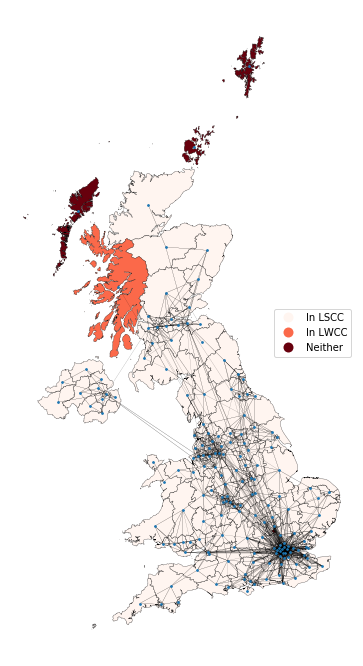

In [47]:
# plot 
fig,ax =plt.subplots(1,figsize =(7,12))
gdf_NUTS3_results = gdf_NUTS3_results.set_geometry('geometry')
gdf_NUTS3_results.plot(linewidth=0.2, ax=ax, column = 'lscc_lwcc', cmap='Reds',edgecolor='0',
                       legend = True,legend_kwds={'loc': 'right'})

nx.draw(G,node_size = 3,width=0.1,ax = ax,pos = NUTS3_no_loc_dict,arrows = False)


gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax, color = 'black',alpha = 0.1)
fig.savefig(root_figure+'/NUTS3_graph'+'/lscc_visualization.pdf', dpi=10,bbox_inches='tight')

### LSCC Timeseries Networks

In [48]:
def rewire_graph(G):
    '''
    Permute nodes in datastructure such that G.nodes() == lscc.nodes()
    '''
    n_nodes = len(G.nodes())
    G_dict = nx.to_dict_of_dicts(G)
    new_dict = {list(lscc_dict.keys())[i] : G_dict[list(lscc_dict.keys())[i]] for i in range(n_nodes)}
    G_new = nx.from_dict_of_dicts(new_dict, create_using = nx.DiGraph)
    
    return G_new

In [49]:
###################################
# Filtering out rows outside LSCC #
###################################

# Get LSCC quadkeys
quadkeys_timeseries_LSCC = set(lscc_dict.keys())

df_filtered = df4.copy()

for i in range(df4.shape[0]):

    start_included =  df4.iloc[i]['start_NUTS3'] in quadkeys_timeseries_LSCC
    end_included = df4.iloc[i]['end_NUTS3'] in quadkeys_timeseries_LSCC 
    included = start_included + end_included

    if included != 2:
        df_filtered = df_filtered.drop([i])

print('Number of deleted rows:', df4.shape[0] - df_filtered.shape[0])

df5 = df_filtered.reset_index(drop=True)

#####################################
# Generate daily DiGraphs from data #
#####################################

# Get the first two quadkey columns
df_key = df5.iloc[:,:2]

M = df5.shape[1]-3
networks_lscc = []

for i in range(1,M,3):

    # Get daily data 
    df_mov = df5.iloc[:,i+1:i+4]
    df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
    df_sum = pd.concat([df_key,df_sum],axis=1)

    # Generate DiGraph 
    N = len(df_sum)
    G = nx.DiGraph()
    # for each row, add nodes and weighted edge
    for j in range(0,N):
        start = df_sum['start_NUTS3'][j]
        end = df_sum['end_NUTS3'][j]
        weight = df_sum['movement'][j]
        G.add_node(start)
        G.add_node(end)
        if weight > 0.0:
            G.add_weighted_edges_from([(start, end, weight)] )

    # Append DiGraph to list of networks
    networks_lscc.append(G)

###########################################
# Permute nodes such that they match LSCC #
###########################################

for i in range(len(networks)):
    networks_lscc[i] = rewire_graph(networks_lscc[i])

########################
# Store daily DiGraphs #
########################

root4 = root_results+'/NUTS3_graph/daily_networks_lscc.pkl'

# Store data (serialize)
with open(root4, 'wb') as handle:
    pickle.dump(networks_lscc, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

Number of deleted rows: 5


# Radius of Gyration For Each NUTS3

### Compute distances in LSCC

In [50]:
#gdf_NUTS3_results = gdf_NUTS3_results.drop('centroids',axis = 1)

gdf_NUTS3_results['nuts_no'] = [NUTS3_dict_no[gdf_NUTS3_results['nuts'][i]] for i in range(len(gdf_NUTS3_results))]
gdf_NUTS3_lscc = gdf_NUTS3_results.copy()
gdf_NUTS3_lscc = gdf_NUTS3_lscc.loc[gdf_NUTS3_lscc['lscc_lwcc'] == 'In LSCC']


In [51]:
# compute aggregated distance matrix between regions
from math import radians, cos, sin, asin, sqrt

nuts_lscc = list(lscc.nodes)
n_nodes = len(nuts_lscc)

def getXY(pt):
    return (pt.x, pt.y)
cens = gdf_NUTS3_lscc['centroid_column']
gdf_NUTS3_lscc['LONGITUDE'],gdf_NUTS3_lscc['LATITUDE'] = [list(t) for t in zip(*map(getXY, cens))]

pt_lat = dict(zip(gdf_NUTS3_lscc['nuts'], gdf_NUTS3_lscc['LATITUDE']))
pt_long = dict(zip(gdf_NUTS3_lscc['nuts'], gdf_NUTS3_lscc['LONGITUDE']))

pt_lat_r = {k: math.radians(v) for k, v in pt_lat.items()}
pt_long_r = {k: math.radians(v) for k, v in pt_long.items()}

pt_tup_1 = []
pt_tup_2 = []
dist_tup = []

# Compute distance in km with Haversine formula
for i in pt_lat_r.keys():
    for j in pt_lat_r.keys():
        pt_tup_1.append(i)
        pt_tup_2.append(j)        
        dist_tup.append(6367 * (2 * asin(sqrt(sin((pt_lat_r.get(i) - pt_lat_r.get(j))/2)**2 + cos((pt_lat_r.get(i))) * cos((pt_lat_r.get(j))) * sin((pt_long_r.get(i) - pt_long_r.get(j))/2)**2))))
        
#Creates Dataframe from tuple
Dist = pd.DataFrame({'start_NUTS3': pt_tup_1,'end_NUTS3': pt_tup_2,'DISTANCE': dist_tup})

# Compute distance matrix D_geom
D_geom = np.zeros((n_nodes,n_nodes))
for i in range(n_nodes):
    D_geom[i,:] = Dist['DISTANCE'][i*n_nodes:(i+1)*n_nodes]
    
# Store D_geom
root_D_geom = root_results + '/NUTS3_graph/base_D_geom_lscc.pickle'
with open(root_D_geom, 'wb') as handle:
    pickle.dump(D_geom, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

### Compute Radius of Gyration

In [52]:
# import data
root4 = root_results+'/NUTS3_graph/daily_networks_lscc.pkl'
with open(root4, 'rb') as handle:
    networks_lscc = pickle.load(handle)
n_networks = len(networks_lscc)

# compute adjacency matrices 
networks_adjacency = [nx.adjacency_matrix(networks_lscc[i]) for i in range(n_networks)]

In [53]:
# import distances matrix
root_D_geom = root_results + '/NUTS3_graph/base_D_geom_lscc.pickle'
with open(root_D_geom, 'rb') as handle:
        D_geom = pickle.load(handle)

In [54]:
# compute radius of gyation evolution

D2_total = (D_geom + np.diag(1000*np.ones(n_nodes)))**2
D2_inter = (D_geom )**2

r_total_nodal = np.zeros((n_days, n_nodes))
r_total_median = []
r_total_Q1 = []
r_total_Q3 = []
r_inter_nodal = np.zeros((n_days, n_nodes))
r_inter_median = []
r_inter_Q1 = []
r_inter_Q3 = []

for i, A in enumerate(networks_adjacency):
    # Get adjacency matrix
    A = A.toarray()
    # Compute out strengths
    d_out = np.sum(A,axis=1)
    # Compute radius of Gyration with self-loops
    r = np.sqrt(np.sum(A/d_out*D2_total, axis = 1))
    r_total_nodal[i,:] = r
    # Without self-loops
    r = np.sqrt(np.sum(A/d_out*D2_inter, axis = 1))
    r_inter_nodal[i,:] = r
    
r_total_median = np.median(r_total_nodal,axis=1)
r_total_Q1 = np.percentile(r_total_nodal,25,axis=1)
r_total_Q3 = np.percentile(r_total_nodal,75,axis=1)
r_inter_median = np.median(r_inter_nodal,axis=1)
r_inter_Q1 = np.percentile(r_inter_nodal,25,axis=1)
r_inter_Q3 = np.percentile(r_inter_nodal,75,axis=1)

# Get start and end dates
start_date = df.columns.values[2][:10]
end_date = df.columns.values[-1][:10]

# Generate DatetimeIndex
days = pd.date_range(start=start_date, end=end_date).date# Store results in dataframe
results = pd.DataFrame({'day':days})
results['r_total_median'] = r_total_median
results['r_total_Q1'] = r_total_Q1
results['r_total_Q3'] = r_total_Q3
results['r_inter_median'] = r_inter_median
results['r_inter_Q1'] = r_inter_Q1
results['r_inter_Q3'] = r_inter_Q3 
    
# Compute baseline values
A = A_LSCC.toarray()
d_out = np.sum(A,axis=1)
r_total_nodal_lscc = np.sqrt(np.sum(A/d_out*D2_total, axis = 1))
r_total_median_lscc = np.percentile(r_total_nodal_lscc,50)
r_total_Q1_lscc = np.percentile(r_total_nodal_lscc,25)
r_total_Q3_lscc = np.percentile(r_total_nodal_lscc,75)

r_inter_nodal_lscc = np.sqrt(np.sum(A/d_out*D2_inter, axis = 1))
r_inter_median_lscc = np.percentile(r_inter_nodal_lscc,50)
r_inter_Q1_lscc = np.percentile(r_inter_nodal_lscc,25)
r_inter_Q3_lscc = np.percentile(r_inter_nodal_lscc,75)

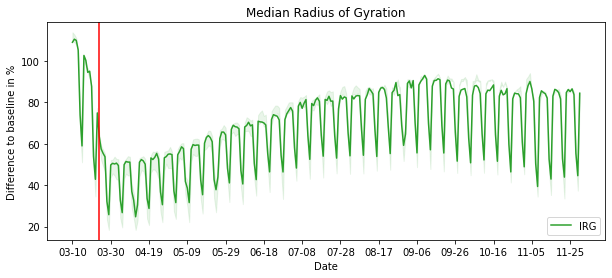

In [55]:
# plot evolution of radius of gyration median
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,4))
ax.plot(100*results['r_inter_median']/r_inter_median_lscc,label='IRG',color='C2')
ax.fill_between(x_days, 100*(results['r_inter_Q3'])/r_inter_Q3_lscc,
               100*(results['r_inter_Q1'])/r_inter_Q1_lscc,
               color = 'C2', alpha = 0.1)
ax.axvline(x = lockdown_date_number, color = 'red')
ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks],ylabel = 'Difference to baseline in %',
      xlabel = 'Date',title='Median Radius of Gyration')
ax.legend(loc=4,frameon = True)
plt.show()

fig.savefig(root_figure+'/Markov_Stability_Timeseries'+'/days_radius_gyration.svg', dpi=fig.dpi,bbox_inches='tight')

In [56]:
# save the median RoG
results['r_inter_median'].to_csv(root_results+'/r_inter_median.csv')

### Fit radius of gyration for each node

In [57]:
# define model asymetric alplacian to fit radius of gyration for all nodes 

def response_asymetric_laplacian(x, alpha,beta,lamb1a,lamb1b,lamb2a,lamb2b,t1,t2, m):
    y = np.zeros(len(x))
    
    t1 = t1*x[-1]/100

    t2 = t2*x[-1]/100

    for i,s in enumerate(x):
        if s <= t1:
             y[i] = (1+m*alpha/beta*(1-np.exp(-beta*s))+alpha/(beta+lamb1a)*(np.exp(lamb1a*(s-t1))-np.exp(-beta*s-lamb1a*t1)))
        else:
             y[i] =(1+m*alpha/beta*(1-np.exp(-beta*s))+
                     alpha/(beta+lamb1a)*(np.exp(-beta*(s-t1))-np.exp(-beta*s-lamb1a*t1))+
                     alpha/(beta-lamb1b)*(np.exp(-lamb1b*(s-t1))-np.exp(-beta*(s-t1))))
        if s<=t2:
            y[i] += (alpha/(beta+lamb2a)*(np.exp(lamb2a*(s-t2))-np.exp(-beta*s-lamb2a*t2)))
        else:
            y[i] +=(alpha/(beta+lamb2a)*(np.exp(-beta*(s-t2))-np.exp(-beta*s-lamb2a*t2))+
                     alpha/(beta-lamb2b)*(np.exp(-lamb2b*(s-t2))-np.exp(-beta*(s-t2))))
    return np.nan_to_num(y)

# call model
mod = lmfit.Model(response_asymetric_laplacian)

# Define parameters
params = lmfit.Parameters()
params.add('alpha', value=-0.04)
params.add('beta', value=0.01, min=0.00001,max = 0.05)
params.add('lamb1a', value=0.1, min=0.00001,max = 0.15)
params.add('lamb1b', value=0.2, min=0.00001,max = 0.3)
params.add('lamb2a', value=0.1, min=0.00001,max =4)
params.add('lamb2b', value=1, min=0.00001,max = 6)
params.add('t1', value=5)
params.add('t2', value=95,max = 200)
params.add('m', value=0)

# Model selection function
def select_model(feature,base_value,name=None):
    '''
    input: time series and baseline value
    output: the response function is fitted to the normalised time series and optimal response parameters
            and CIs are returned with a model quality assesment
    '''
    
    ################
    # Select Model #
    ################
    
    # Compute MM
    signal = pd.Series(pd.Series(feature/base_value))
    
    signal_mm = np.roll(np.asarray(signal.rolling(window = 7, win_type='triang').mean()),-3)
    x_mm = np.arange(len(signal))[np.nan_to_num(signal_mm)>0]
    signal_mm = signal_mm[np.nan_to_num(signal_mm)>0]
    
    # Compute AIC for m=0
    params['m'].vary = False
    params['t1'].vary = False
    ls1 = mod.fit(signal_mm, params, x=x_mm)
    ls = ls1
    bic1 = ls1.bic
    
    #Add CVRMSE
    result_string = str(name) + ' & '
    signal_mean = np.mean(signal)
    prediction = ls.eval(ls.params, x=np.arange(len(signal)))
    CVRMSE = np.sqrt(metrics.mean_absolute_error(signal,prediction))/signal_mean
    result_string+=str(np.around(CVRMSE,3))+' & '
        
    # Add BIC
    result_string+=str(np.around(bic1,1))#+' & '+str(np.around(bic2,1))
    
    # Print report
    print(result_string+'\n')
    
    return ls



In [58]:
compute_again = False
if compute_again == True:
    r_ls_models = []
    #n_nodes
    for i in range(n_nodes):
        model = select_model(r_total_nodal[:,i],r_total_nodal_lscc[i],'Node'+str(i))
        r_ls_models.append(model)
    root5 = root_results+'NUTS3_graph'+'r_ls_models.pkl'
    with open(root5, 'wb') as handle:
        pickle.dump(r_ls_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [59]:
# read the stores radius of gyration fits
root5 = root_results+'NUTS3_graph'+'r_ls_models.pkl'
with open(root5, 'rb') as handle:
        r_ls_models = pickle.load(handle)

#### Visualize fits for all nodes

In [60]:
%%capture
for i in range(r_total_nodal.shape[1]): #n_nodes
    model_node_no = list(G.nodes)[i]
    fig,ax = plt.subplots(1,figsize = (7,4))
    ax.plot(100*r_total_nodal[:,i]/r_total_nodal_lscc[i],color = 'teal',alpha = 0.5)
    ax.plot(100*r_ls_models[i].eval(r_ls_models[i].params, x=x_days),'teal')

    model = r_ls_models[i]
    model_t2 = np.round(model.params['t2'].value,2)
    model_alpha = abs(np.round(model.params['alpha'].value,2))
    model_beta = model.params['beta'].value
    model_1_beta = np.round(1/model_beta,1)
    ticks = range(0,n_days,50)
    ax.set(xticks = ticks, xticklabels = days_dm[ticks])

    ax.set_xlabel('Date',fontsize = 14)
    ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
    ax.set_title(r'Node {}, Low $\alpha$ & Low $1/\beta$'.format(model_node_no),fontsize = 16)

    if model_node_no == 89:
        ax.set_title(r'Node {}, Low $\alpha$ & Low $1/\beta$'.format(model_node_no),fontsize = 16)
        ax.annotate(r'$\alpha$={}, $1/\beta$={}'.format(model_alpha,model_1_beta),(40,102),size = 18,color = 'black')
    if model_node_no == 59:
        ax.set_title(r'Node {}, Low $\alpha$ & High $1/\beta$'.format(model_node_no),fontsize = 16)
        ax.annotate(r'$\alpha$={}, $1/\beta$={}'.format(model_alpha,model_1_beta),(40,95),size = 18,color = 'black')
    if model_node_no == 28:
        ax.set_title(r'Node {}, High $\alpha$ & High $1/\beta$'.format(model_node_no),fontsize = 16)
        ax.annotate(r'$\alpha$={}, $1/\beta$={}'.format(model_alpha,model_1_beta),(40,95),size = 18,color = 'black')
    if model_node_no == 20:
        ax.set_title(r'Node {}, High $\alpha$ & Low $1/\beta$'.format(model_node_no),fontsize = 16)
        ax.annotate(r'$\alpha$={}, $1/\beta$={}'.format(model_alpha,model_1_beta),(38,100),size = 18,color = 'black')

    #ax.legend(fontsize = 12)


##### Visualize the 4 selected ones 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


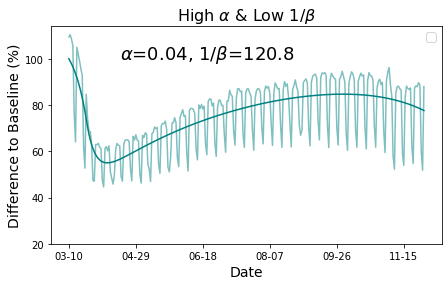

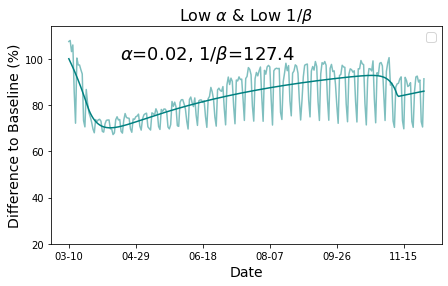

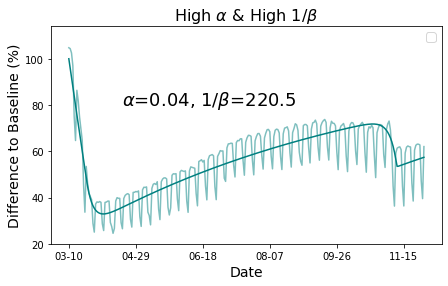

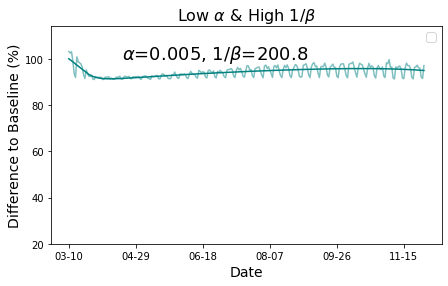

In [61]:
for i in range(r_total_nodal.shape[1]): #n_nodes
    model_node_no = list(G.nodes)[i]
    if (model_node_no == 89) or (model_node_no == 59) or (model_node_no == 28) or (model_node_no == 20):
        fig,ax = plt.subplots(1,figsize = (7,4))
        ax.plot(100*r_total_nodal[:,i]/r_total_nodal_lscc[i],color = 'teal',alpha = 0.5,)
        ax.plot(100*r_ls_models[i].eval(r_ls_models[i].params, x=x_days),'teal')
        ax.set_ylim((20,114))
        model = r_ls_models[i]
        model_t2 = np.round(model.params['t2'].value,2)
        model_alpha = abs(np.round(model.params['alpha'].value,2))
        model_beta = model.params['beta'].value
        model_1_beta = np.round(1/model_beta,1)
        ticks = range(0,n_days,50)
        ax.set(xticks = ticks, xticklabels = days_dm[ticks])
        ax.set_xlabel('Date',fontsize = 14)
        ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
        
        if model_node_no == 28:
            ax.set_title(r'High $\alpha$ & High $1/\beta$',fontsize = 16)
            ax.annotate(r'$\alpha$={}, $1/\beta$={}'.format(model_alpha,model_1_beta),(40,80),size = 18,color = 'black')
            fig.savefig(root_figure+'/Socioeconomic'+'/HH.pdf',dpi=fig.dpi,bbox_inches='tight')
        if model_node_no == 59:
            ax.set_title(r'Low $\alpha$ & High $1/\beta$',fontsize = 16)
            ax.annotate(r'$\alpha$=0.005, $1/\beta$={}'.format(model_1_beta),(40,100),size = 18,color = 'black')
            fig.savefig(root_figure+'/Socioeconomic'+'/LH.pdf',dpi=fig.dpi,bbox_inches='tight')
        if model_node_no == 89:
            ax.set_title(r'Low $\alpha$ & Low $1/\beta$',fontsize = 16)
            ax.annotate(r'$\alpha$={}, $1/\beta$={}'.format(model_alpha,model_1_beta),(38,100),size = 18,color = 'black')
            fig.savefig(root_figure+'/Socioeconomic'+'/LL.pdf',dpi=fig.dpi,bbox_inches='tight')
        if model_node_no == 20:
            ax.set_title(r'High $\alpha$ & Low $1/\beta$',fontsize = 16)
            ax.annotate(r'$\alpha$={}, $1/\beta$={}'.format(model_alpha,model_1_beta),(38,100),size = 18,color = 'black')
            fig.savefig(root_figure+'/Socioeconomic'+'/HL.pdf',dpi=fig.dpi,bbox_inches='tight')
            
        ax.legend(fontsize = 12)
            

### Map of alpha and 1/beta distributions

In [62]:
## extract all parameter values from the fits
alphas = []
betas = []
lamb1as = []
lamb1bs = []
lamb2as = []
lamb2bs = []
t1s = []
t2s = []
ms = []

## loop for al nodes
for i in range(len(lscc.nodes())):
    alphas.append(r_ls_models[i].params['alpha'].value)
    betas.append(r_ls_models[i].params['beta'].value)
    lamb1as.append(r_ls_models[i].params['lamb1a'].value)
    lamb1bs.append(r_ls_models[i].params['lamb1b'].value)
    lamb2as.append(r_ls_models[i].params['lamb2a'].value)
    lamb2bs.append(r_ls_models[i].params['lamb2b'].value)
    t1s.append(r_ls_models[i].params['t1'].value)
    t2s.append(r_ls_models[i].params['t2'].value)
    ms.append(r_ls_models[i].params['m'].value)

# store results in dataframe
results_params = pd.DataFrame({'node':lscc.nodes(),'alpha':alphas,'beta':betas,'lamb1a':lamb1as,
                             'lamb1b':lamb1bs,'lamb2a':lamb2as,'lamb2b':lamb2bs,'t1':t1s,'t2':t2s,'m':ms})

In [63]:
# rename columns
results_params = results_params.rename(columns={"node": "nuts_no"})

#copy
gdf_NUTS3_results_in_lscc = gdf_NUTS3_results.copy()

# select those only in the LSCC
gdf_NUTS3_results_in_lscc = gdf_NUTS3_results_in_lscc.loc[gdf_NUTS3_results_in_lscc['lscc_lwcc']=='In LSCC']

# merge with geodatafrme
gdf_NUTS3_results_in_lscc = pd.merge(results_params, gdf_NUTS3_results_in_lscc, how="inner", on=["nuts_no"])

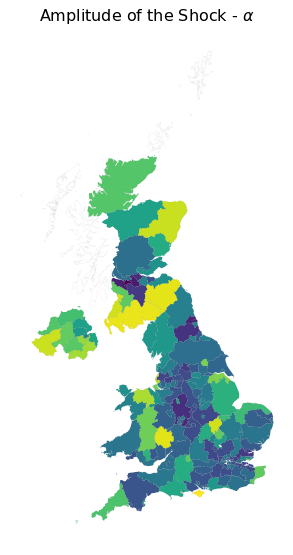

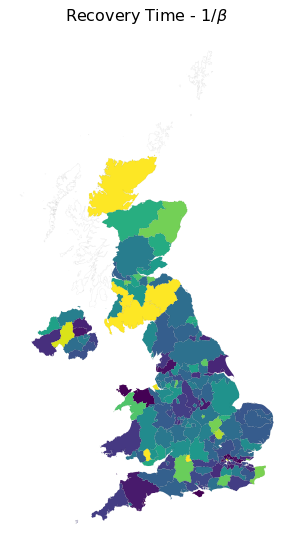

In [64]:
# Plot distribution in the map of the two parameters

gdf_NUTS3_results_in_lscc = gdf_NUTS3_results_in_lscc.set_geometry('geometry')
#gdf_NUTS3_results_in_lscc['abs_alpha'] = abs(gdf_NUTS3_results_in_lscc['alpha'])
gdf_NUTS3_results_in_lscc['1_beta'] = 1/gdf_NUTS3_results_in_lscc['beta']
columns = ['alpha','1_beta','beta','lamb1a','lamb1b','lamb2a','lamb2b','t1','t2','m']

    
fig,ax =plt.subplots(1,figsize =(5,10))
gdf_NUTS3_results_in_lscc.plot(linewidth=0, ax=ax, column = 'alpha', cmap='viridis',edgecolor='0',
                               legend = False,
                               legend_kwds={'label': "{}".format(columns[0]),'orientation': "horizontal"})
ax.set_axis_off()
plt.title(r'Amplitude of the Shock - $\alpha$',fontsize = 16)
#nx.draw(G,node_size = 3,width=0.1,ax = ax,pos = NUTS3_no_loc_dict,arrows = False)
gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax, color = 'black',alpha = 0.05)
fig.savefig(root_figure+'/NUTS3_graph'+'/alpha.pdf', dpi=fig.dpi,bbox_inches='tight')

####################################################################################
    
fig,ax =plt.subplots(1,figsize =(5,10))
gdf_NUTS3_results_in_lscc.plot(linewidth=0, ax=ax, column = '1_beta', cmap='viridis',edgecolor='0',
                               legend = False,vmax = 230,vmin = 90,
                               legend_kwds={'label': "{}".format(columns[1]),'orientation': "horizontal"})
ax.set_axis_off()
plt.title(r'Recovery Time - $1/\beta$',fontsize = 16)
#nx.draw(G,node_size = 3,width=0.1,ax = ax,pos = NUTS3_no_loc_dict,arrows = False)
gdf_NUTS3.boundary.plot(linewidth=0.5, ax=ax, color = 'black',alpha = 0.05)
fig.savefig(root_figure+'/NUTS3_graph'+'/beta.pdf', dpi=fig.dpi,bbox_inches='tight')